## The Simultaneous Perturbation Stochastic Approximation (SPSA) algorithm 

In [22]:
import numpy as np
import math
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sympy import *
from scipy.stats import bernoulli

%matplotlib inline

Here we present the standard (first order) SPSA algorithm. The basic idea of the algorithm is shown in the figure below (from https://arxiv.org/pdf/1704.05018.pdf):
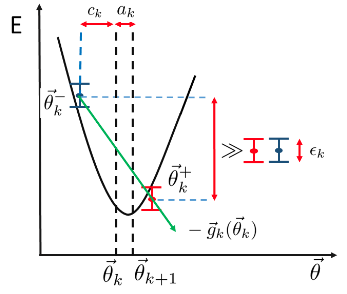
The algorithm is similar to the gradient descent but the gradient is being replaced by a "simultaneous perturbation" estimate of it. If $E$ is our objective function and $\theta$ the vector of variables we are minimizing over, the picture shows the value of $\theta$ at iteration $k$, $\theta_k$ and how the iterate $\theta_{k+1}$ is calculated. The direction of next step is randomly selected from a Bernoulli distribution of $\pm 1$ values. Note that other distributions can be used but need to pecify certain criteria for convergence of the algorithm; normal and uniform do not. See:

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.19.4562&rep=rep1&type=pdf 

for details. If $\Delta_k$ represents the randomly selected vector of $\pm 1$, the algorithm calculates two values $\theta_k^-$ and $\theta_k^+$ as follows:
$$\theta_k^- = \theta_k- c_k * \Delta_k \ \ , \ \ \ \theta_k^+ = \theta_k+ c_k * \Delta_k$$
where $c_k=\frac{c}{k^\gamma}$ is an iteration adjusted parameter. The fact that all components of the $\theta$ vector are perturbed at the same time gives the simultaneous perturbation name to the algorihtm. The function values at these two points, are used to calculate the gradient:
$$g_k=\frac{E(\theta_k^+)-E(\theta_k^-)}{2c_k} \Delta_k$$
Note that we need only two measurements of $E$ per iteration. Also, these measurements may not be accurate but as long as the difference $E(\theta_k^+)-E(\theta_k^-)$ is larger than any error $\epsilon_k$ in the measurement the algorithm will work. Having estimated the gradient $g_k$ we can get a new $\theta$:
$$\theta_{k+1} = \theta_k - a_k g_k(\theta_k)$$
where $a_k=\frac{a}{(k+A)^\alpha}$ is a iteration adjusted parameter. 

To summarize, the algotihm works as follows:
1. Select parameters $a$, $c$, $A$, $\alpha$, $\gamma$.
2. Select initial guess for $\theta$ and set iteration $k=0$.
3. Update $a_k$ and $c_k$
4. Draw random vector $\Delta$ from Bernoulli $\pm 1$ distribution. 
5. Calculate $\theta^-$ and $\theta^+$
6. Calculate the function values at $\theta^-$ and $\theta^+$. If the value is larger than a threshold discard the iteration, set $k=k+1$ and go to Step 3.
7. Calculate the new gradient $g_k$ and the new $\theta$
8. If the new $\theta$ is too far from the previous one discard the iteration, set $k=k+1$ and go to Step 3. 
9. Otherwise upate the $\theta$, set $k=k+1$ and go to  Step 3

The algorithm is very sensitive to the parameter settings which, besides the fact that they need to fulfill certain conditions to gurantee convergence, need to be calibrated. Discussions about how to calibrate can be found in the two papers in the links provided above. 

We start with the Rosenbrock function using `sympy`. In this example we are assuming that our measurements of the function are accurate (not-noisy). One can add an error to these as described in the references above. 

In [19]:
x1,x2=symbols("x1 x2")
f=Matrix([100*(x2-x1**2)**2+(1-x1)**2])
X=Matrix([x1,x2])
f

Matrix([[(1 - x1)**2 + 100*(-x1**2 + x2)**2]])

Following the suggestions in the tewo references mentioned earlier to set the initial parameters, we run the algorithm below until the changes in $\theta$ are not significant (as defined by the $\epsilon$ parameter. Changing the parameters will change the behavior of the algorithm. One can set the number of iterations $n$ and run as many as needed to get to converge. Given the depndence of $a_k$ and $c_k$ on the current iteration $k$ this means that the algorithm may not change $\theta$ for many iterations, so the condition in the `while` loop below may not always signify convergence. 

In [326]:
n=1000
fv=lambdify((x1,x2),100*(x2-x1**2)**2+(1-x1)**2)
A=300.
alpha=0.502
gamma=0.101
a=0.077
c=0.01
theta=[0,0]
ftol=10000
epsilon=0.0000000001
k=1 
dtheta=[1,1]
plx=[theta[0]]
ply=[theta[1]]
while (np.linalg.norm(dtheta) > epsilon):
    a_k=a/((k+A)**alpha)
    c_k=c/(k**gamma)
    delta=2*np.round(np.random.binomial(size=2,p=0.5,n=1))-1
    thetap=theta+c_k*delta
    thetam=theta-c_k*delta
    yp=fv(thetap[0],thetap[1])
    ym=fv(thetam[0],thetam[1])
    grc=(yp-ym)/(2*c_k)
    gr[0]=grc/delta[0]
    gr[1]=grc/delta[1]
    prevf=fv(theta[0],theta[1])
    newtheta=theta-a_k*gr
    if (abs(fv(new[0],new[1])-prevf) < ftol):
        dtheta= newtheta-theta
        if (np.linalg.norm(dtheta) < 10):
            theta=newtheta
    k=k+1
    if (100*int(k/100) == k):
        plx.append(theta[0])
        ply.append(theta[1])
print('Terminated after ',k,' iterations with theta: ',theta)


Terminated after  9867  iterations with theta:  [0.99346455 0.98696553]


The figure below shows the progress of the algorithm every 100 iterations. It can be seen that, as expected, the direction of the path is not always improving the objective function.

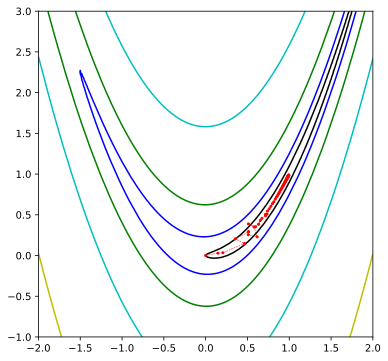

In [328]:
from scipy.optimize import rosen
npts = 201
x, y = np.mgrid[-2:2:npts*1j, -1:3:npts*1j]
x.shape = (npts**2)
y.shape = (npts**2)
z = rosen(np.vstack((x, y)))
x.shape = (npts, npts)
y.shape = (npts, npts)
z.shape = (npts, npts)
fig = plt.figure(figsize=(6,6))
ax1 = fig.subplots()
# Plots/
levels = np.logspace(0, 3.2, 5)
#plt.cla()
ax1.contour(x, y, z, levels,colors = ['k','b','g','c','y'])
ax1.plot(plx,ply,'ro--',markersize=2,linewidth=0.5)